# lab4:PCA与流形学习

In [26]:
# Run some setup code for this notebook.
import matplotlib.pyplot as plt
import numpy as np


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 10) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.导入数据与预处理

In [27]:
import pandas as pd
df = pd.read_csv('./data/mnist.csv') 
data = df.values
X = data[:, 1:]
y = data[:, 0]

print(f"{X.shape = }, {y.shape = }")
print(f"{y = }")

X.shape = (407, 784), y.shape = (407,)
y = array([3, 9, 3, 3, 2, 6, 2, 2, 3, 6, 9, 9, 9, 9, 2, 3, 9, 2, 6, 3, 9, 2,
       2, 3, 9, 6, 3, 3, 9, 6, 2, 6, 9, 2, 9, 9, 9, 6, 3, 6, 6, 2, 9, 2,
       9, 2, 2, 6, 2, 9, 9, 6, 6, 6, 3, 3, 3, 3, 3, 9, 6, 6, 9, 6, 9, 3,
       2, 2, 6, 9, 3, 9, 6, 2, 3, 6, 3, 2, 6, 2, 9, 9, 3, 9, 6, 6, 3, 3,
       6, 3, 6, 3, 6, 3, 2, 3, 2, 2, 9, 2, 3, 2, 2, 6, 3, 2, 9, 2, 6, 9,
       6, 2, 2, 2, 9, 6, 9, 3, 2, 6, 2, 9, 2, 2, 9, 9, 2, 9, 9, 3, 2, 3,
       6, 3, 6, 3, 9, 2, 9, 3, 3, 9, 6, 2, 6, 2, 9, 6, 2, 2, 2, 9, 2, 2,
       6, 3, 2, 9, 6, 2, 9, 6, 3, 2, 9, 3, 3, 3, 6, 2, 6, 6, 2, 2, 3, 6,
       6, 9, 3, 2, 9, 2, 9, 9, 6, 2, 6, 9, 9, 3, 2, 2, 2, 2, 9, 3, 6, 2,
       2, 9, 2, 2, 3, 9, 2, 2, 3, 3, 9, 6, 9, 6, 2, 3, 2, 2, 9, 2, 6, 9,
       2, 3, 2, 9, 2, 6, 9, 9, 2, 3, 9, 3, 9, 2, 3, 6, 2, 2, 2, 2, 3, 6,
       6, 9, 6, 3, 3, 2, 2, 6, 3, 6, 3, 9, 3, 9, 2, 3, 2, 3, 6, 6, 9, 2,
       6, 2, 9, 2, 2, 9, 6, 9, 6, 2, 2, 3, 9, 9, 2, 6, 9, 6, 3, 6, 3, 6,
       3

## 2.主成分分析（PCA）

In [28]:
# 实现pca算法并与对比sklearn
class myPCA:
    def __init__(self, data):
        """
        init a PCA class

        Args:
            - data: the data to be processed
        """
        self.data = data.astype(np.float64)
        # 标准化
        means = np.mean(self.data, axis=0)
        self.data -= means
        std_dev = np.std(self.data, axis=0)
        std_dev[std_dev == 0] = 1
        self.data /= std_dev
        # 计算协方差矩阵
        self.cov = np.cov(self.data, rowvar=False) # rowvar=False表示每一列代表一个特征
        # 计算特征值和特征向量
        self.eig_vals, self.eig_vecs = np.linalg.eig(self.cov) # eig_vecs的每一列是一个特征向量
        # 对特征值进行排序
        self.eig_vals_sorted_idx = np.argsort(self.eig_vals)[::-1] # 从大到小排序


    def get_d(self, t=0.95):
        """
        get the number of dimensions to be retained

        Args:
            - t: float, refactoring thresholds

        Returns:
            - d: int, the number of dimensions to be retained
        """
        for d in range(1, self.data.shape[1]+1):
            if np.sum(self.eig_vals[self.eig_vals_sorted_idx[:d]]) / np.sum(self.eig_vals) >= t:
                return d
            
    def get_w(self, d):
        """
        get the projection matrix

        Args:
            - d: int, the number of dimensions to be retained

        Returns:
            - w: ndarray, the projection matrix
        """
        return self.eig_vecs[:, self.eig_vals_sorted_idx[:d]]


### 考虑到minist数据集的特殊性，我们将其转换为十维数据

In [29]:
model_p = myPCA(X)
dimensions = 10
W = model_p.get_w(dimensions)
X_pca = model_p.data.dot(W.real)
print(X_pca.shape)

(407, 10)


### Compare with sklearn
在这里我们首先利用sklearn库计算myPCA的重构误差

In [30]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

W_pinv = np.linalg.pinv(W.real)
X_reconstructed = X_pca.dot(W_pinv)
# 按均方损失计算myPCA的重构误差
reconstruction_error = mean_squared_error(model_p.data, X_reconstructed)
print(f"{reconstruction_error = }")
print(f"{dimensions = }")

reconstruction_error = 0.4582524616813594
dimensions = 10


然后与使用sklearn库的PCA进行比较

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=dimensions)

pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

# 按均方损失计算sklearn的重构误差
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)

print(f"{reconstruction_error = }")

print("原始数据维度:", X.shape)
print("降维后数据维度:", X_pca.shape)

reconstruction_error = 0.45825809421109626
原始数据维度: (407, 784)
降维后数据维度: (407, 10)


C:\Users\86135\AppData\Local\Temp\ipykernel_22476\1112224550.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('jet', 10))


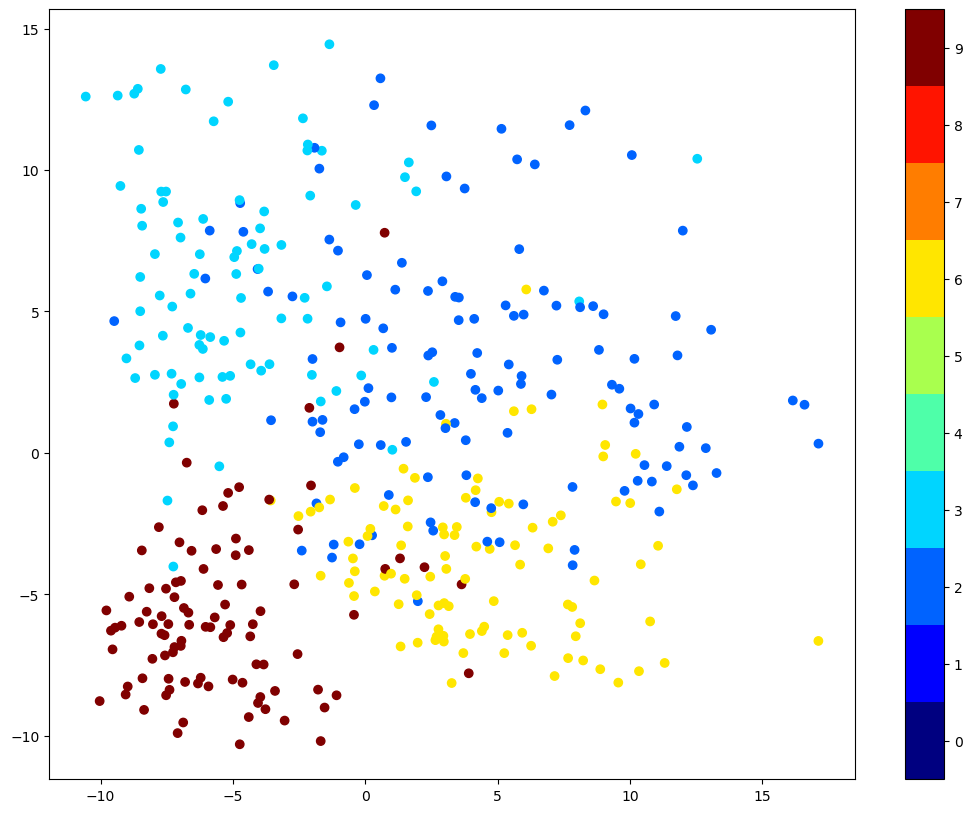

In [32]:
# 画出降维后的数据分布
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

## 3.流形学习

In [7]:
class myMDS:
    def __init__(self, data):
        """
        init a MDS class

        Args:
            - data: the data to be processed
        """
        self.data = data.astype(np.float64)
        # 计算距离矩阵
        diff = self.data[:, np.newaxis, :] - self.data[np.newaxis, :, :]
        self.dist = np.sqrt(np.sum(diff**2, axis=-1))
        # 计算dist^2_i. 
        self.dist2_i = np.sum(self.dist**2, axis=1) / self.data.shape[0]
        # 计算dist^2_j.
        self.dist2_j = np.sum(self.dist**2, axis=0) / self.data.shape[0]
        # 计算dist^2.
        self.dist2 = np.sum(self.dist**2) / (self.data.shape[0]**2)
        # 计算B.
        self.B = np.zeros((self.data.shape[0], self.data.shape[0]))
        for i in range(self.data.shape[0]):
            for j in range(i+1, self.data.shape[0]):
                self.B[i, j] = -0.5 * (self.dist[i, j]**2 - self.dist2_i[i] - self.dist2_j[j] + self.dist2)
                self.B[j, i] = self.B[i, j]
        # 计算特征值和特征向量
        self.eig_vals, self.eig_vecs = np.linalg.eig(self.B)
        # 对特征值进行排序
        self.eig_vals_sorted_idx = np.argsort(self.eig_vals)[::-1]

    def project(self, d):
        """
        project the data to d dimensions

        Args:
            - d: int, the number of dimensions to be retained

        Returns:
            - X_mds: ndarray, the projected data
        """
        # 选取d个最大的特征值,按从大到小的顺序组成对角矩阵
        Lambda = np.diag(self.eig_vals[self.eig_vals_sorted_idx[:d]])
        # 选取d个最大的特征向量,按从大到小的顺序组成矩阵
        V = self.eig_vecs[:, self.eig_vals_sorted_idx[:d]]
        # 计算X_mds
        X_mds = np.sqrt(Lambda).dot(V.T)
        return X_mds.T

### 二维

In [8]:
# 实现流形学习算法
model_m = myMDS(X)
X_reduced = model_m.project(2)

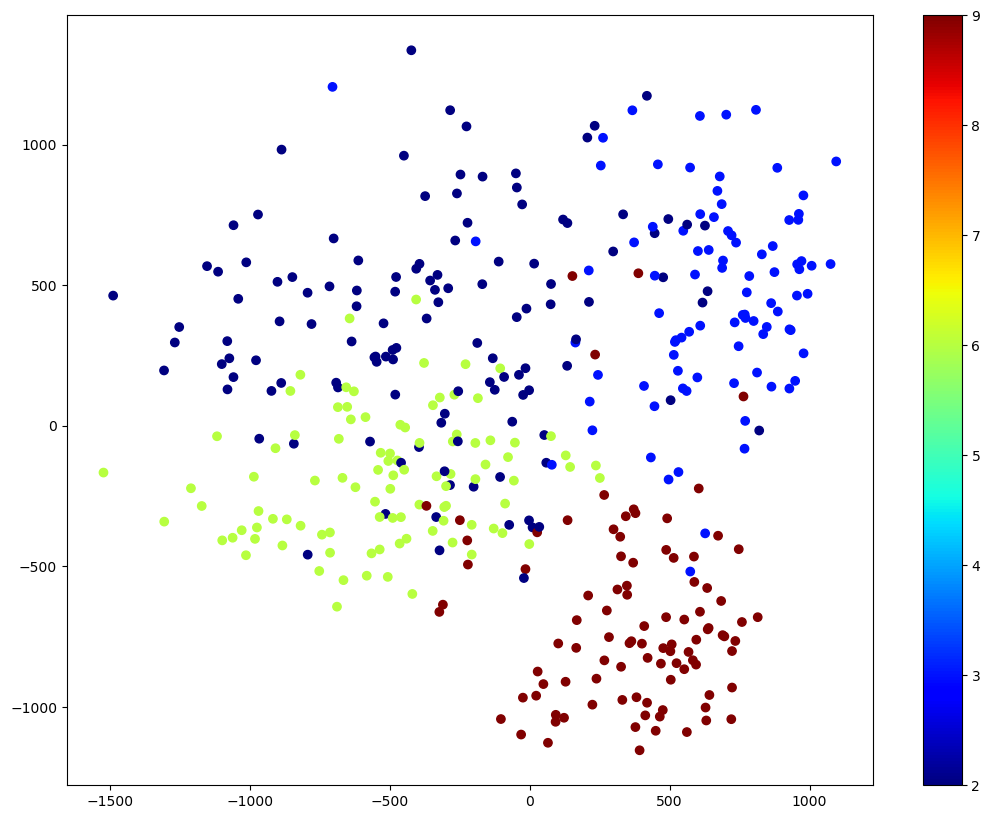

In [9]:
# 可视化降维结果
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.colorbar()
plt.show()

### 三维

In [10]:
model_m = myMDS(X)
X_reduced = model_m.project(3)

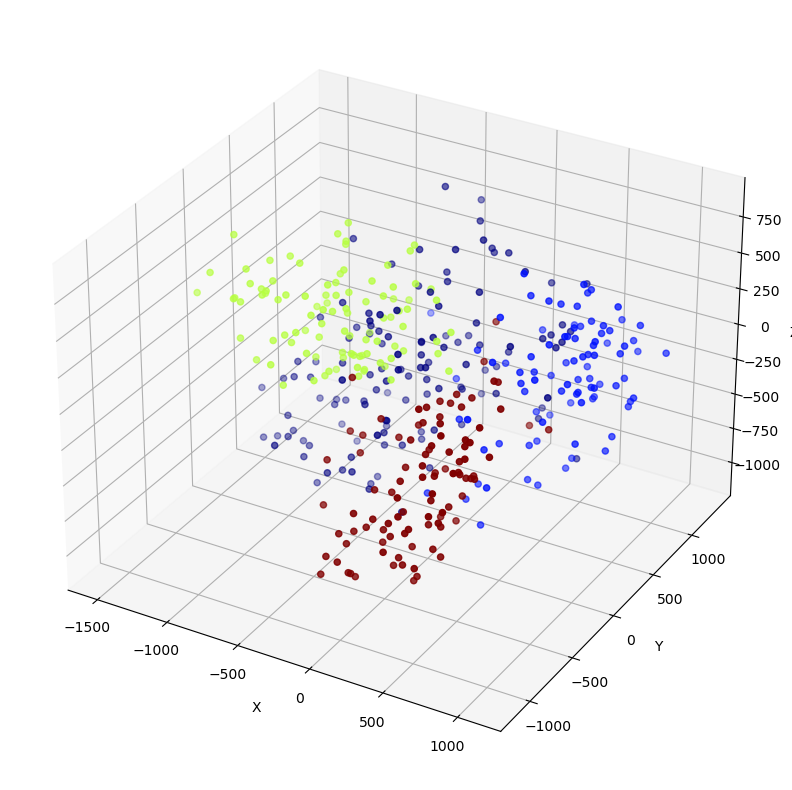

In [11]:
# 创建 3D 图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 散点图
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap="jet")

# 设置标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()